# Time series anomaly detection
This tutorial is an introduction to time series anomaly detection using TensorFlow.

Anomaly detection is a problem with implementations in a wide variety of domains. It involves the identification of
novel or unexpected observations or sequences within the data being captured. 

In this tutorial different styles of LSTM models are trained using a series of data stock market prices.
Reconstruction error between the original and predicted data is used to determine the anomalies.
In the last step, anomalies are plotted over the original data to visualize the results.
### Covid19
affected the markets so was not a surprise that the algorithms found most novel market
behavior over the outbreaks waves and lockdowns.

This tutorial includes five sections:

1. Data preprocessing.
2. Training on LSTM neural network. LSTM stands for Long-Short Term Memory
3. Reconstruction of the data based on LSTM prediction functionality.
4. Mean Absolute Error (MAE) computation between original and reconstructed data.
5. Anomalies detection and plotting.

credit: TensorFlow.org for some of their work included in this tutorial

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Sat Apr 10 18:22:15 2021

@author: ion_g
"""
#import libraries
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
import IPython
import IPython.display

np.random.seed(1)
tf.random.set_seed(1)
clear_console = True #Clear console after each run?


# Read stock prices from finance.yahoo.com

In [4]:
%%time

df = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/BKHYY?period1=1201824000&period2=1617753600&interval=1d&events=history&includeAdjustedClose=true',)

#Convert date from string to datetime64[ns]
df['Date'] = pd.to_datetime(df['Date'])
print(df['Date'].min(), df['Date'].max())

#Print some information about the input data 
print('data shape:\n', df.shape)
print('start sequence data samples:\n', df[:5])
print('end sequence data samples:\n', df[-5:])
print('data frame columns:\n', df.info())


2008-02-01 00:00:00 2021-04-06 00:00:00
data shape:
 (3317, 7)
start sequence data samples:
         Date   Open   High    Low  Close  Adj Close  Volume
0 2008-02-01  24.15  24.15  24.15  24.15  21.200817     100
1 2008-02-04  24.15  24.15  24.15  24.15  21.200817       0
2 2008-02-05  24.15  24.15  24.15  24.15  21.200817       0
3 2008-02-06  24.15  24.15  24.15  24.15  21.200817       0
4 2008-02-07  23.10  23.10  23.10  23.10  20.279041     200
end sequence data samples:
            Date       Open       High        Low      Close  Adj Close  Volume
3312 2021-03-30  37.209999  37.209999  37.209999  37.209999  37.209999       0
3313 2021-03-31  37.209999  37.209999  37.209999  37.209999  37.209999       0
3314 2021-04-01  37.209999  37.209999  37.209999  37.209999  37.209999     100
3315 2021-04-05  37.209999  37.209999  37.209999  37.209999  37.209999       0
3316 2021-04-06  37.209999  37.209999  37.209999  37.209999  37.209999     100
<class 'pandas.core.frame.DataFrame'>
RangeIn

# Plot data
Get first impresion about the data that will be used in this tutorial

0       24.150000
1       24.150000
2       24.150000
3       24.150000
4       23.100000
          ...    
3312    37.209999
3313    37.209999
3314    37.209999
3315    37.209999
3316    37.209999
Name: Open, Length: 3317, dtype: float64


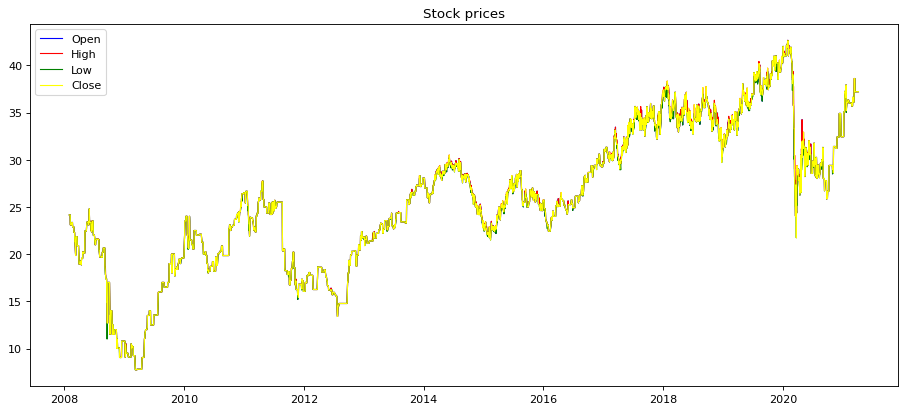

0       24.150000
1       24.150000
2       24.150000
3       24.150000
4       23.100000
          ...    
3312    37.209999
3313    37.209999
3314    37.209999
3315    37.209999
3316    37.209999
Name: Open, Length: 3317, dtype: float64


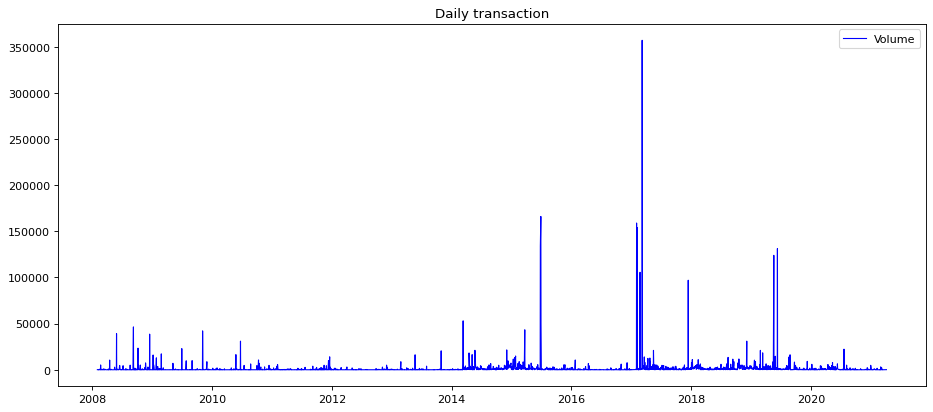

In [5]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = df.shape[0]
print(df['Open'])
ax.set_title("Stock prices")
ax.plot(df['Date'], df['Open'], '-', color='blue', animated = True, linewidth=1)
ax.plot(df['Date'], df['High'], '-', color='red', animated = True, linewidth=1)
ax.plot(df['Date'], df['Low'], '-', color='green', animated = True, linewidth=1)
ax.plot(df['Date'], df['Close'], '-', color='yellow', animated = True, linewidth=1)
plt.legend(['Open', 'High','Low','Close'])
plt.show()

fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = df.shape[0]
print(df['Open'])
ax.set_title("Daily transaction")
ax.plot(df['Date'], df['Volume'], '-', color='blue', animated = True, linewidth=1)
plt.legend(['Volume'])
plt.show()
print()

# Split data into train and test samples
Using test data to validate the model could help even that the time series windowing will supply test target for each time sequence.

In [6]:
train = df.loc[df['Date'] <= '2021-12-31']
test  = df.loc[df['Date'] >  '2021-12-31']
print(f'train shape {train.shape}, train shape {test.shape}')
print(f'train tail\n {train.tail()}\ntest head:\n {test.head()}')
if (clear_console):
    IPython.display.clear_output()
print()

# 1. Data preprocessing.
## Normalize the data
It is important to scale features before training a neural network. 
Normalization is a common way of doing this scaling. 
"sklearn" package provides MinMaxScaler object to normalize data between 1 and -1 
depending on Max and Min values for each feature.

In [7]:
print('Transform data using scaler')
train_scaled = train.copy()
scalers={}
columns= ['Open','High','Low','Close','Adj Close','Volume']
for i in columns: # train.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train_scaled[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers[f'scaler_{i}'] = scaler
    train_scaled[i]=s_s
print('\nOriginal feature values:\n', train.head(10))
print('\nNormalized feature values:\n', train_scaled.head(10))

if (clear_console):
    IPython.display.clear_output()
print()

# Data windowing
The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.
The main features of the input windows are:
* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both.

In this tutorial I used a window of 30 day history (starting each day in the past) and one day test data.

For example, a model that makes a prediction of one step into the future, given six time steps of history would need a window like this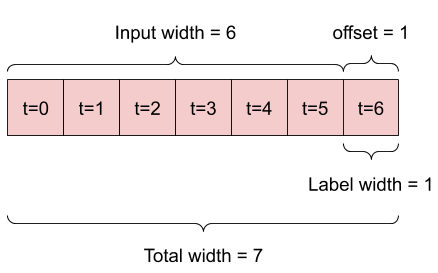 
Credit to The TensorFlow Authors.


In [8]:
TIME_STEPS=30
n_past = 30
n_future = 1 
n_features = len(columns)
def split_series(series, n_past, n_future, dates ):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  
  X, y, t = list(), list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future, date = series[window_start:past_end, :], series[past_end:future_end, :], dates[past_end],
    X.append(past)
    y.append(future)
    t.append(date)
    
  return np.array(X), np.array(y), t

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])   
    return np.array(Xs), np.array(ys)
 
X_train, y_train, time_serie = split_series(train_scaled[columns].values,n_past, n_future, train_scaled['Date'])
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
if (clear_console):
    IPython.display.clear_output()
print()

# RNN model with one LSTM hidden layer
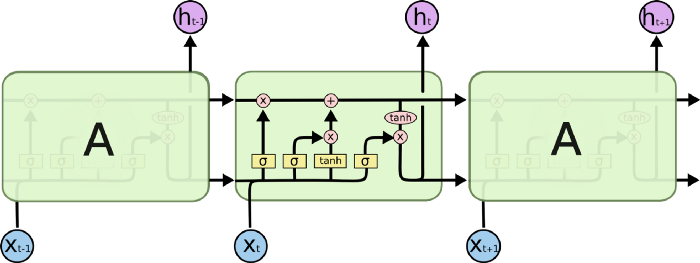

In [9]:
# In[Build model]

model = Sequential()
model.add(LSTM(128, input_shape=(n_past, n_features)))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')

model.summary()
if (clear_console):
    IPython.display.clear_output()
print()

model => loss: 0.04580 val_loss: 0.04615


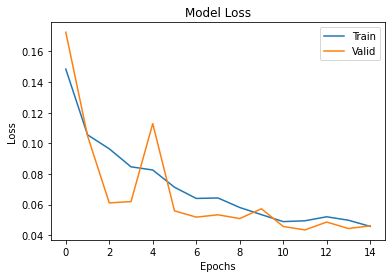

Wall time: 1min 45s


In [340]:
%%time
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
Epochs = 20

history = model.fit(X_train, y_train, epochs=Epochs, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], 
                    shuffle=False)
IPython.display.clear_output()
print(f"model => loss: {history.history['loss'][-1]:.5f} val_loss: {history.history['val_loss'][-1]:.5f}")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()


In [10]:
%%time
# define Autoencoder model
#E2D2 128 Units
model128 = Sequential()
model128.add(LSTM(180, activation='relu', input_shape=(n_past, n_features), return_sequences=True))
model128.add(LSTM(32, activation='relu', return_sequences=False))
model128.add(RepeatVector((X_train.shape[1])))
model128.add(LSTM(32, activation='relu', return_sequences=True))
model128.add(LSTM(180, activation='relu', return_sequences=True))
model128.add(TimeDistributed(Dense(n_features)))

model128.compile(optimizer='adam', loss='mse')
model128.summary()
if (clear_console):
    IPython.display.clear_output()
print()


CPU times: user 583 ms, sys: 13.6 ms, total: 597 ms
Wall time: 582 ms


model128 => loss: 0.00409 val_loss: 0.00994


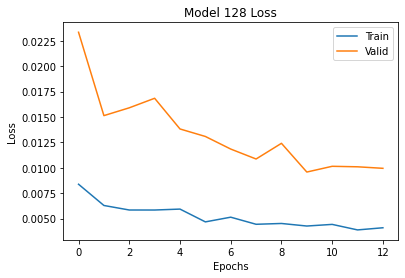

Wall time: 1min 58s


In [361]:
%%time
history128 = model128.fit(X_train, y_train, epochs=Epochs, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, 
                                                             mode='min', verbose=1)], shuffle=False)
history128 = model128.fit(X_train, y_train, epochs=Epochs, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, 
                                                             mode='min', verbose=1)], shuffle=False)

IPython.display.clear_output()

print(f"model128 => loss: {history128.history['loss'][-1]:.5f} val_loss: {history128.history['val_loss'][-1]:.5f}")
plt.plot(history128.history['loss'])
plt.plot(history128.history['val_loss'])
plt.title("Model 128 Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()
pred128_e1d1=model_e1d1.predict(X_train)


In [11]:
%%time
# Model Architecture
#
# E1D1: One hidden layer encoder, one hidden layer decoder
# n_features ==> no of features at each timestep in the data.
# n_past ==> time steps in the past used for each sample at a given time
# Sample = X[t]  
# Past = X[t-1],X[t-2],X[t-3],X[t-4],X[t-5],X[t-6],X[t-7],X[t-8],X[t-9],X[t-10]

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(10, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

decoder_l1 = tf.keras.layers.LSTM(10, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
model_e1d1.compile(optimizer='adam', loss='mae')
model_e1d1.summary()
if (clear_console):
    IPython.display.clear_output()
print()


CPU times: user 1.1 s, sys: 16.3 ms, total: 1.11 s
Wall time: 1.11 s


model_e1d1 => loss: 0.02898 val_loss: 0.05541


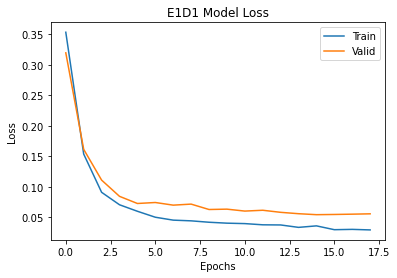

Wall time: 22.1 s


In [344]:
%%time
# In[fit model_e1d1]
history_e1d1 = model_e1d1.fit(X_train, y_train, epochs=Epochs*2, batch_size=32, validation_split=0.1,
                     callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

IPython.display.clear_output()

print(f"model_e1d1 => loss: {history_e1d1.history['loss'][-1]:.5f} val_loss: {history_e1d1.history['val_loss'][-1]:.5f}")
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()
pred1_e1d1=model_e1d1.predict(X_train)

In [345]:
%%time
# Model Architecture
#
# E2D2: Two hidden layers encoder, two hidden layers decoder
# Convulation units: 100, 50, 1, 50, 100
# Return sequence and returns state (memory)
# n_features ==> no of features at each timestep in the data.
# n_past ==> time steps in the past used for each sample at a given time
# Sample = X[t]  
# Past = X[t-1],X[t-2],X[t-3],X[t-4],X[t-5],X[t-6],X[t-7],X[t-8],X[t-9],X[t-10]

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(50, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

#Repeater => transfer data from encoder (Encoder outputs) to decoder (decoder inputs)
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])

#Decoders
decoder_l1 = tf.keras.layers.LSTM(50, return_sequences=True)(decoder_inputs,initial_state = encoder_states2)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states1)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
model_e2d2.compile(optimizer='adam', loss='mae')

model_e2d2.summary()
if (clear_console):
    IPython.display.clear_output()
print()


Wall time: 1.01 s


model_e2d2 ==> loss: 0.04988, val_loss: 0.07199


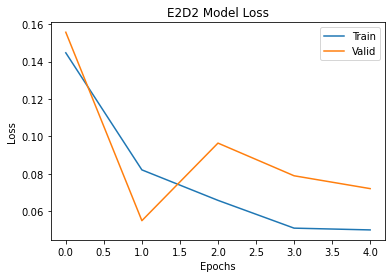

Wall time: 45 s


In [346]:
%%time
# In[fit model_e2d2]
history_e2d2 = model_e2d2.fit(X_train, y_train, epochs=Epochs, batch_size=32, validation_split=0.1,
                      callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

#history_e2d2=model_e1d1.fit(X_train, y_train,epochs=Epochs,batch_size=32,
                            # verbose=0,
#                            validation_split=0.1,
#                            callbacks=[reduce_lr])

IPython.display.clear_output()

print(f"model_e2d2 ==> loss: {history_e2d2.history['loss'][-1]:.5f}, val_loss: {history_e2d2.history['val_loss'][-1]:.5f}")
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()


In [347]:
%%time
# Model Architecture
#
# E2D2: Two hidden layers encoder, two hidden layers decoder
# n_features ==> no of features at each timestep in the data.
# n_past ==> time steps in the past used for each sample at a given time
# Sample = X[t]  
# Past = X[t-1],X[t-2],X[t-3],X[t-4],X[t-5],X[t-6],X[t-7],X[t-8],X[t-9],X[t-10]

encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True,return_sequences = True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_l2 = tf.keras.layers.LSTM(50, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])

decoder_l1 = tf.keras.layers.LSTM(50, return_sequences=True)
decoder_outputs1 = decoder_l1(decoder_inputs,initial_state = encoder_states2)
decoder_states2 = decoder_outputs1[1:]
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)
decoder_outputs2 = decoder_l2(decoder_outputs1)
decoder_states3 = decoder_outputs2[1:]
decoder_outputs3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_outputs2)

model2_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs3)
model2_e2d2.compile(optimizer='adam', loss='mae')

model2_e2d2.summary()
if (clear_console):
    IPython.display.clear_output()
print()


Wall time: 5.3 s


model2_e2d2 ==> loss: 0.01542, val_loss: 0.03209


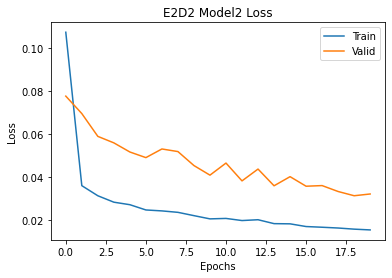

Wall time: 1min 24s


In [348]:
%%time
# In[fit model1_e2d2]
history2_e2d2=model2_e2d2.fit(X_train, y_train,epochs=Epochs,batch_size=32,
                            # verbose=0,
                            validation_split=0.1,
                            callbacks=[reduce_lr])
IPython.display.clear_output()
print(f"model2_e2d2 ==> loss: {history2_e2d2.history['loss'][-1]:.5f}, val_loss: {history2_e2d2.history['val_loss'][-1]:.5f}")
plt.plot(history2_e2d2.history['loss'])
plt.plot(history2_e2d2.history['val_loss'])
plt.title("E2D2 Model2 Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()


# Compare models

In [362]:
#Compare models
print(f"model       ==> loss: {history.history['loss'][-1]:.5f}, val_loss: {history.history['val_loss'][-1]:.5f}")
print(f"model_e2d2  ==> loss: {history_e2d2.history['loss'][-1]:.5f}, val_loss: {history_e2d2.history['val_loss'][-1]:.5f}")
print(f"model_e1d1  ==> loss: {history_e1d1.history['loss'][-1]:.5f}, val_loss: {history_e1d1.history['val_loss'][-1]:.5f}")
print(f"model2_e2d2 ==> loss: {history2_e2d2.history['loss'][-1]:.5f}, val_loss: {history2_e2d2.history['val_loss'][-1]:.5f}")
print(f"model128    ==> loss: {history128.history['loss'][-1]:.5f}, val_loss: {history128.history['val_loss'][-1]:.5f}")

model       ==> loss: 0.04580, val_loss: 0.04615
model_e2d2  ==> loss: 0.04988, val_loss: 0.07199
model_e1d1  ==> loss: 0.02898, val_loss: 0.05541
model2_e2d2 ==> loss: 0.01542, val_loss: 0.03209
model128    ==> loss: 0.00409, val_loss: 0.00994


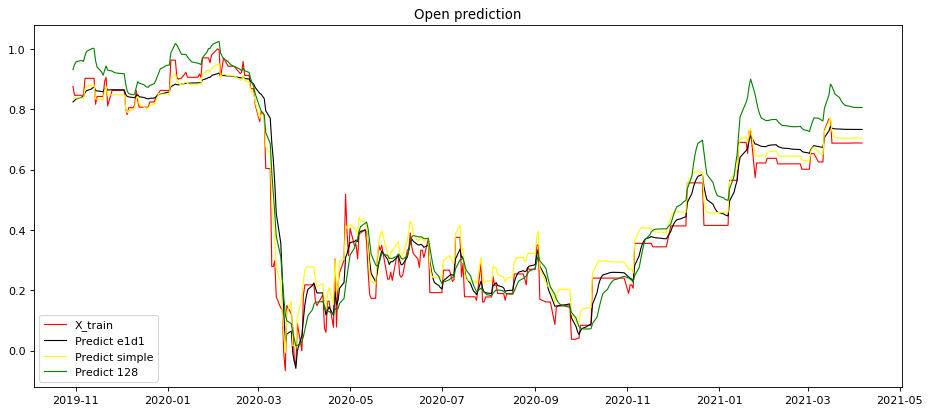

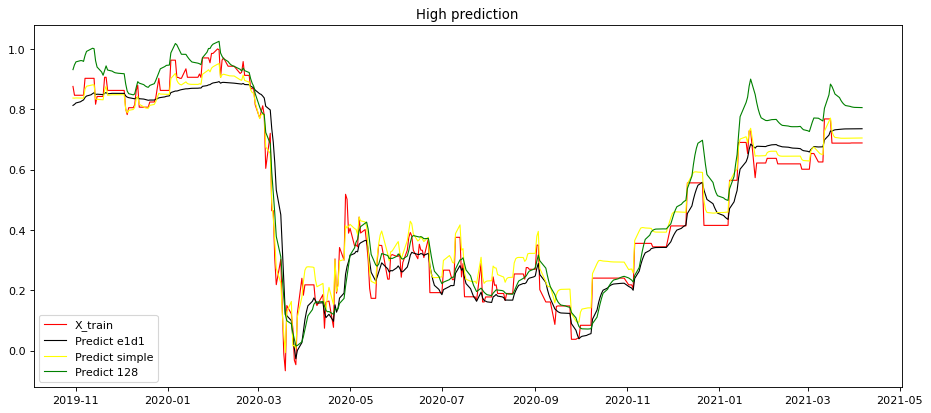

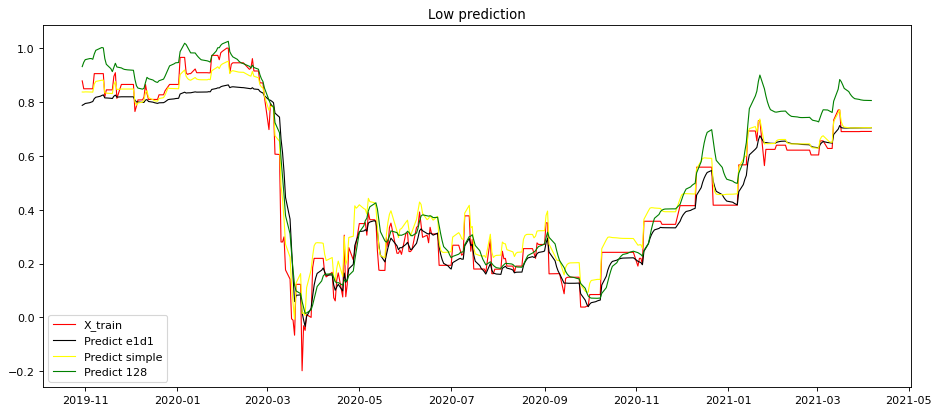

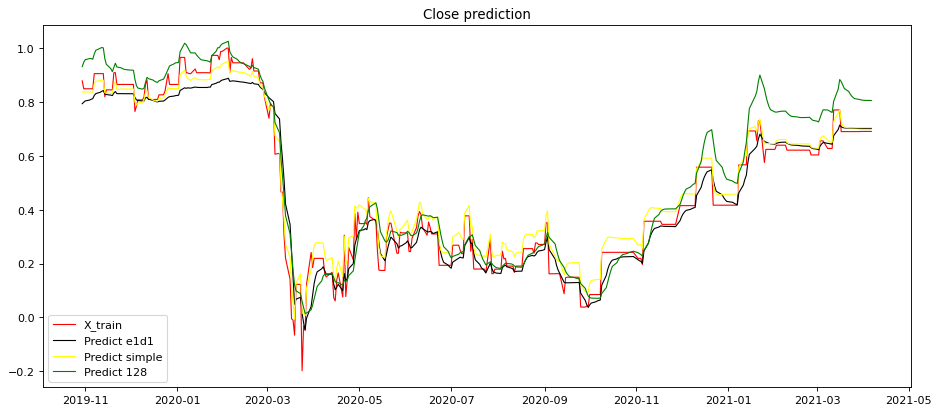

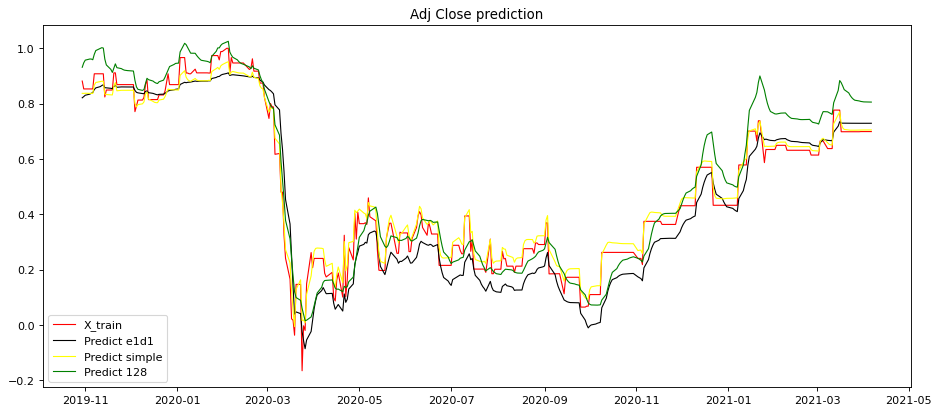

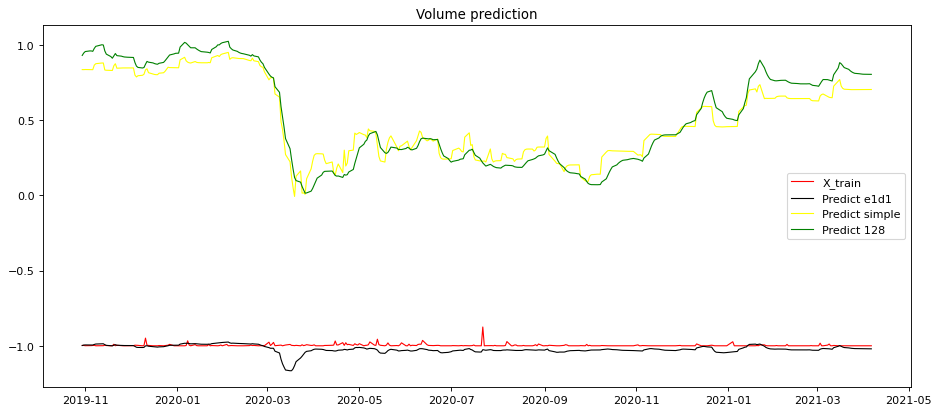

Wall time: 9.74 s


In [363]:
%%time
# In[plot prediction]
pred_model=model.predict(X_train)
pred_e1d1=model_e1d1.predict(X_train)
pred_e2d2=model_e2d2.predict(X_train)
pred2_e2d2=model2_e2d2.predict(X_train)
pred128=model128.predict(X_train)

for i in range(len(columns)):
   fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
   ax.plot(time_serie[-360:], X_train[-360:,29,i], '-', color='red', animated = True, linewidth=1)
   ax.plot(time_serie[-360:], pred_e1d1[-360:,0,i], '-', color='black', animated = True, linewidth=1)
   ax.plot(time_serie[-360:], pred_model[-360:,0,0], '-', color='yellow', animated = True, linewidth=1)
   ax.plot(time_serie[-360:], pred128[-360:,0,0], '-', color='green', animated = True, linewidth=1)
   plt.title(f"{columns[i]} prediction")
   # plt.xlabel('Epochs')
   # plt.ylabel('Loss')
   plt.legend(['X_train', 'Predict e1d1','Predict simple', 'Predict 128'])
   plt.show()

In [364]:
%%time
# Unscale data
# Convert prediction to original data scale

pred1_e2d2_unscaled=pred1_e2d2.copy()
pred1_e1d1_unscaled=pred1_e1d1.copy()
pred1_unscaled=pred1.copy()
pred2_e2d2_unscaled=pred2_e2d2.copy()
pred128_unscaled=pred128.copy()

for index,i in enumerate(columns):
    scaler = scalers[f'scaler_{i}']
    pred1_e2d2_unscaled[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])   
    pred1_e1d1_unscaled[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])   
    pred1_unscaled[:,:,index]=scaler.inverse_transform(pred1[:,:,index])
    pred2_e2d2_unscaled[:,:,index]=scaler.inverse_transform(pred2_e2d2[:,:,index])
    pred128_unscaled[:,:,index]=scaler.inverse_transform(pred128[:,:,index])
if (clear_console):
    IPython.display.clear_output()
print()


Wall time: 24 ms


In [365]:
# In[calculate RMSE]
from math import sqrt
from sklearn.metrics import mean_squared_error

for i in range(len(columns)):
   rmse = sqrt(mean_squared_error(y_train[:,:,i], pred128[:,29,i]))
   print(f'{columns[i]:10s} Test RMSE: %.3f' % rmse)

Open       Test RMSE: 0.080
High       Test RMSE: 0.078
Low        Test RMSE: 0.083
Close      Test RMSE: 0.081
Adj Close  Test RMSE: 0.112
Volume     Test RMSE: 0.059


# Anomaly detection
Anomaly is where reconstruction error is large.
We can define this value beyond which we call anomaly.
Let us look at MAE in training prediction


Wall time: 124 ms


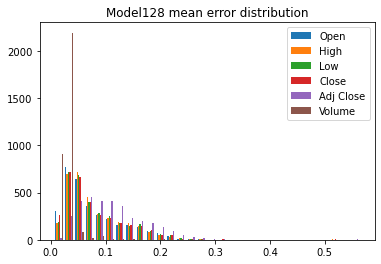

In [376]:
%%time
trainMAE = np.mean(np.abs(pred128 - X_train), axis=1)
plt.title(f"Model128 mean error distribution")
plt.hist(trainMAE, bins=30)
plt.legend(columns)
histogram = np.histogram(trainMAE, bins=30, range=None, normed=None, weights=None, density=None)
print(histogram)
max_trainMAE = histogram[1][12] #Define max threshold.

anomaly_df = pd.DataFrame(pred128_unscaled[:,0,:],columns=columns)
for i in range(len(columns)):
   anomaly_df[f'MAE {columns[i]}'] = trainMAE[:,i]
   anomaly_df[f'anomaly {columns[i]}'] = anomaly_df[f'MAE {columns[i]}']  > max_trainMAE
  
if (clear_console):
    IPython.display.clear_output()
print()

# Plot anomalies

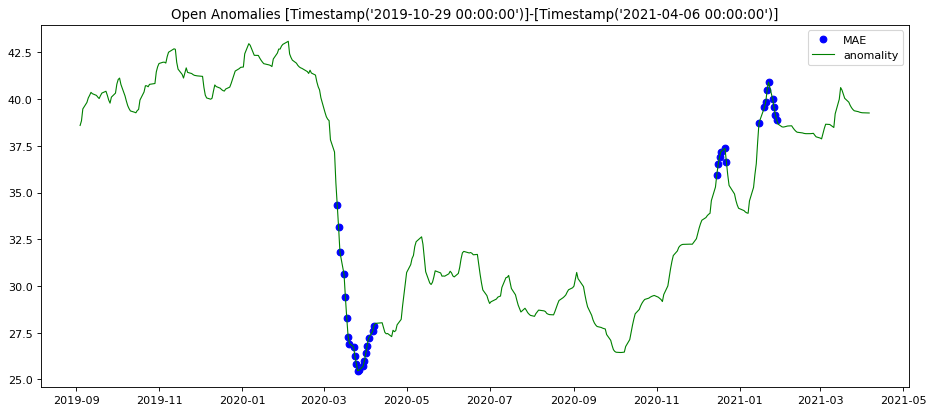

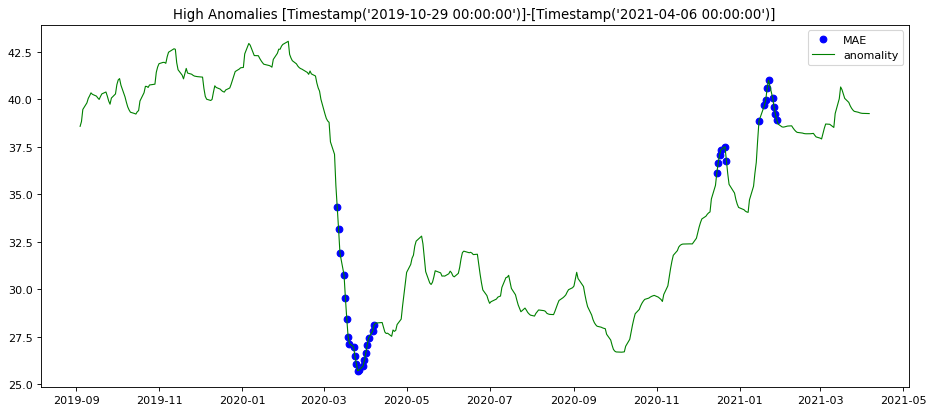

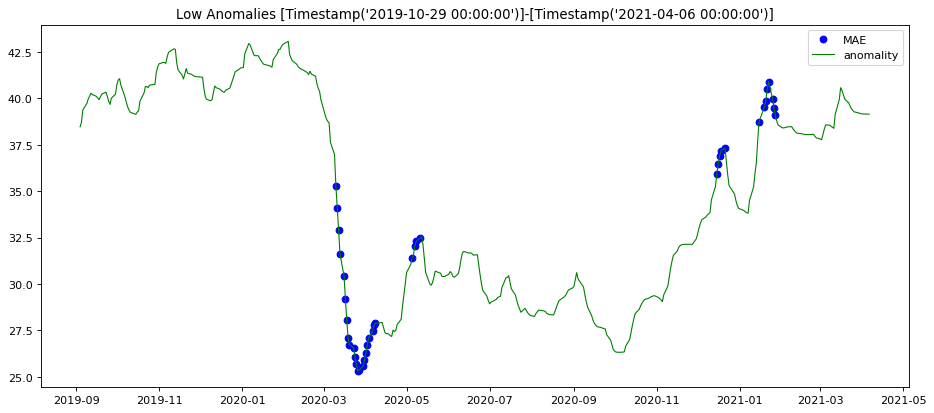

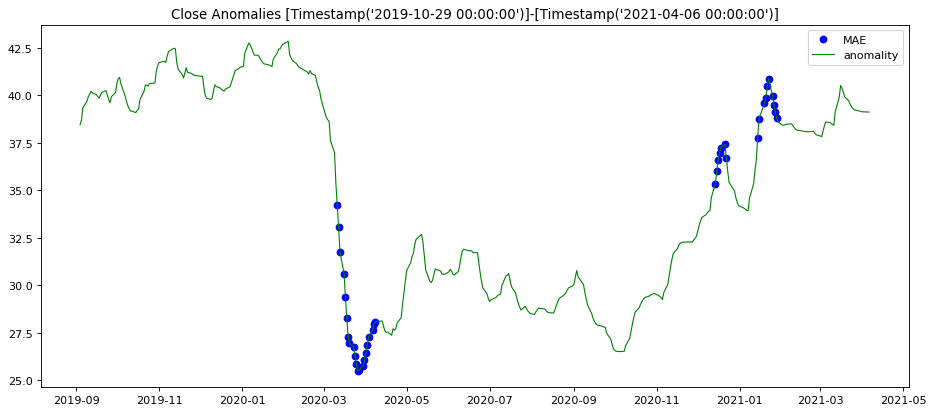

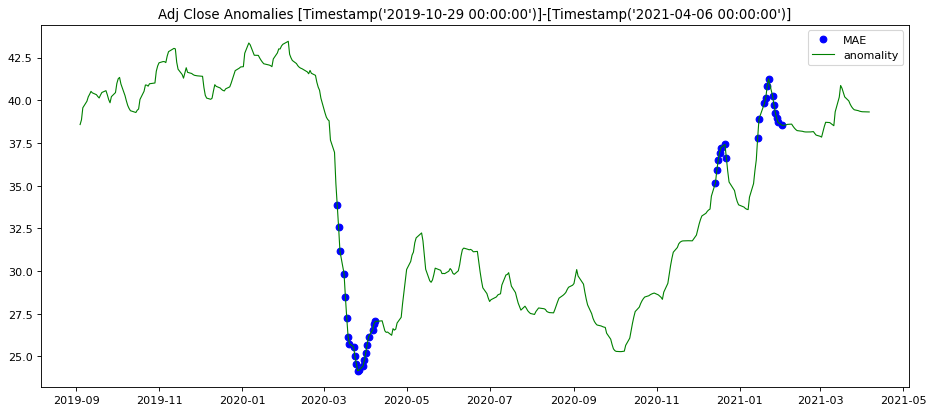

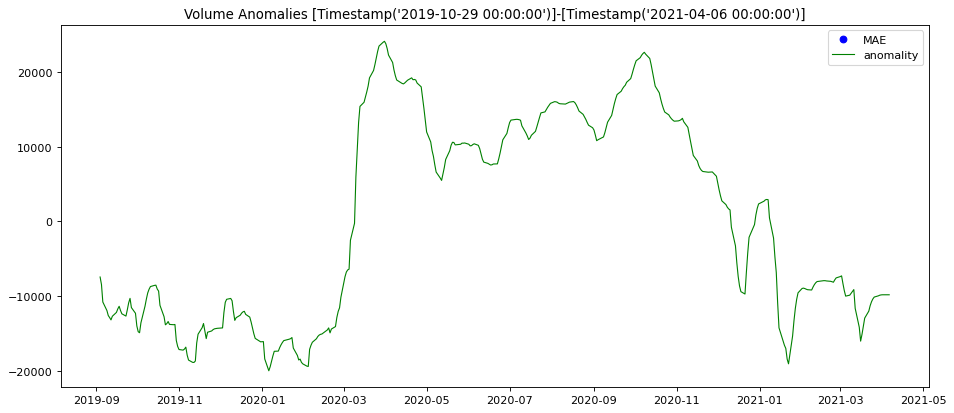

Wall time: 1.37 s


In [377]:
%%time 
for i in columns:
   fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
   ax.plot(time_serie[-400:], anomaly_df[f'{i}'][-400:] /anomaly_df[f'anomaly {i}'][-400:], 'o', color='blue', animated = True, linewidth=1)
   ax.plot(time_serie[-400:], anomaly_df[f'{i}'][-400:], '-', color='green', animated = True, linewidth=1)
   plt.title(f"{i} Anomalies {time_serie[-361:-360]}-{time_serie[-1:]}")
   plt.legend(['MAE', 'anomality','{1}'])
   plt.show()
